In [1]:
## 施設名のエンコーディング
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

ModuleNotFoundError: No module named 'torch'

In [ ]:
class FacilityDataset(Dataset):
    def __init__(self, facilities, targets=None):
        self.facilities = facilities
        self.targets = targets
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_len = 128

    def __len__(self):
        return len(self.facilities)

    def __getitem__(self, idx):
        facility = str(self.facilities[idx])
        inputs = self.tokenizer.encode_plus(
            facility,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(self.targets[idx], dtype=torch.float)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
            }
            
train_df = pd.read_csv('train.csv')
facilities = train_df['FacilityName'].values
train_dataset = FacilityDataset(facilities, train_df['GHG_Direct_Emissions_14_in_metric_tons'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class BertRegressor(nn.Module):
    def __init__(self):
        super(BertRegressor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, ids, mask, token_type_ids):
        outputs = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]  # BERTのプーリングされた出力を取得
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
def rmsle_loss(y_pred, y_true):
    return torch.sqrt(torch.mean((torch.log1p(y_pred) - torch.log1p(y_true)) ** 2))

In [ ]:
model = BertRegressor()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=1e-5)

def train_model(model, train_loader, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            ids = batch['ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
            mask = batch['mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
            token_type_ids = batch['token_type_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
            targets = batch['targets'].to('cuda' if torch.cuda.is_available() else 'cpu')

            outputs = model(ids, mask, token_type_ids)
            loss = rmsle_loss(outputs, targets.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

train_model(model, train_loader, optimizer, num_epochs=5)

## 本題

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


from sklearn.model_selection import KFold
from sklearn.metrics import *

import gc
gc.collect()

import os

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [2]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df["County"], test_df["County"]
del train_df["FacilityName"], test_df["FacilityName"]

In [3]:
train_df.sample(5)

,Latitude,Longitude,LocationAddress,City,State,ZIP,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
450,30.028300,-99.105600,"E OF KERRVILLE, 2.5 MI SE OF S",KERRVILLE,TX,78028,48265.0,562212,NaN,Waste,NaN,NaN,NaN,NaN,67735.530996,69770.250256,17768.077601,49613.400470,38571.094723
1341,36.426265,-95.700203,7300 EAST HIGHWAY 88 & HIGHWAY 169,OOLOGAH,OK,74053,40131.0,221112,NaN,Power Plants,30649.440983,32522.726803,33896.081326,31084.575926,76919.491029,42671.280209,62374.185541,61621.301824,50451.563857
549,NaN,NaN,NaN,OFFSHORE,LA,0,NaN,211111,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205123.350324,260407.356638
3501,45.632107,-88.358675,200 C. AVE,GOODMAN,WI,54125,55075.0,321211,NaN,Other,NaN,NaN,NaN,NaN,62761.208186,55636.531076,49538.505054,26075.866889,44922.554836
531,39.732754,-75.517487,1706 E 12TH STREET,WILMINGTON,DE,19809-3562,10003.0,562212,NaN,Waste,NaN,NaN,NaN,NaN,54689.683588,42273.435298,25318.556395,55003.580193,44538.682504


In [4]:
# primaryNAICSCodeを文字列に変換
train_df['PrimaryNAICS'] = train_df['PrimaryNAICS'].astype(str)
test_df['PrimaryNAICS'] = test_df['PrimaryNAICS'].astype(str)

# 5文字に変換
train_df['PrimaryNAICS'] = train_df['PrimaryNAICS'].apply(lambda x: x[:5])
test_df['PrimaryNAICS'] = test_df['PrimaryNAICS'].apply(lambda x: x[:5])

train_df.head()

,Latitude,Longitude,LocationAddress,City,State,ZIP,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
0,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,17183.0,32612,NaN,Other,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,37907.936721,45598.125851,52973.139946
1,38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,54039.0,48621,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,55507.543666,72387.334115,58225.196089,76376.547318,55910.066617
2,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,54085.0,21111,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55679.543214
3,35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,6029.0,22111,NaN,Power Plants,NaN,NaN,NaN,NaN,54811.222708,69339.923002,63647.340038,53799.011225,61411.902782
4,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,39035.0,22111,NaN,Power Plants,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,77391.157768,17662.966241,43100.469774


In [5]:
# secondaryNAICSCodeを削除
del train_df["SecondPrimaryNAICS"], test_df["SecondPrimaryNAICS"]

### クラスタリング

In [6]:
from sklearn.cluster import KMeans

def create_cluster(df, n_clusters=100):
    df_ = df[['Latitude', 'Longitude']]
    cluster = KMeans(n_clusters=n_clusters)
    # もしdf_がnanを含むならば、その行のdf['cluster'] = -1
    df['cluster'] = 0
    df['cluster'][df_.isna().any(axis=1)] = -1
    # それ以外の行については、clusterを予測
    df['cluster'][~df_.isna().any(axis=1)] = cluster.fit_predict(df_[~df_.isna().any(axis=1)])
    # clusterが-1の行の個数がdf_.isna().any(axis=1)の個数と一致するか確認
    assert len(df['cluster'][df['cluster'] == -1]) == len(df_[df_.isna().any(axis=1)])
    score = silhouette_score(df_[~df_.isna().any(axis=1)], df['cluster'][~df_.isna().any(axis=1)])
    return df, score


# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
# 進行度を表示
from tqdm import tqdm

def grid_search_cluster(df_, cluster_num_list):
    df = df_.copy()
    df = df.dropna(subset=['Latitude', 'Longitude'])
    best_score = -1
    best_cluster_num = -1
    for cluster_num in tqdm(cluster_num_list):
        _, score = create_cluster(df, cluster_num)
        if score > best_score:
            best_score = score
            best_cluster_num = cluster_num
            
    return best_score, best_cluster_num

cluster_num_list = np.arange(10, 1000, 10)

best_score, best_cluster_num = grid_search_cluster(train_df, cluster_num_list)
best_cluster_num

  3%|▎         | 3/99 [00:03<02:05,  1.31s/it]


KeyboardInterrupt: 

In [7]:
train_test_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
train_test_df = create_cluster(train_test_df, 500)[0]
train_df = train_test_df.iloc[:len(train_df), :]
test_df = train_test_df.iloc[len(train_df):, :]
print(f"latitude or longitude is NaN: {train_test_df[['Latitude', 'Longitude']].isna().any(axis=1).sum()}")
print(f"Number of clusters -1: {len(train_test_df[train_test_df['cluster']==-1])}")
del train_test_df

latitude or longitude is NaN: 158
Number of clusters -1: 158


In [9]:
train_df['cluster'].value_counts()

# clusterごとに所属しているデータの数が1以下のものの割合
bad_cluster_num = 0
for cluster in train_df['cluster'].unique():
    if cluster == -1:
        continue
    if len(train_df[train_df['cluster'] == cluster]) <= 1:
        bad_cluster_num += 1
bad_cluster_num / (len(train_df['cluster'].unique()) - 1)
    

0.030364372469635626

In [10]:
# clusterをマップに表示
import folium
from folium.plugins import MarkerCluster

def display_cluster(df, cluster_column='cluster'):
    # クラスター毎に色を変える
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
              'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
              'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
              'gray', 'black', 'lightgray']
    df = df.dropna(subset=['Latitude', 'Longitude'])
    m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=5)
    
    # 各クラスターにマーカーを追加
    for cluster in df[cluster_column].unique():
        df_ = df[df[cluster_column] == cluster]
        marker_cluster = MarkerCluster(name=f'Cluster {cluster}', icon_create_function=f"""
            function(cluster) {{
                return L.divIcon({{
                    html: '<div style="background-color: {colors[cluster%len(colors)]}; width: 30px; height: 30px; border-radius: 50%; text-align: center; line-height: 30px;">' + cluster.getChildCount() + '</div>',
                    className: 'marker-cluster'
                }});
            }}
        """).add_to(m)
        for i in range(len(df_)):
            folium.Marker(
                location=[df_['Latitude'].values[i], df_['Longitude'].values[i]],
                popup=None,
                icon=folium.Icon(color=colors[cluster%len(colors)])
            ).add_to(marker_cluster)
            
    return m
    

#display_cluster(train_df)

In [11]:
train_df['cluster'] = train_df['cluster'].astype(str)
test_df['cluster'] = test_df['cluster'].astype(str)

# drop latitude, longitude
del train_df['Latitude'], train_df['Longitude'], test_df['Latitude'], test_df['Longitude']
# drop state
del train_df['State'], test_df['State']
# drop FIPScode
del train_df['FIPScode'], test_df['FIPScode']
# drop city
del train_df['City'], test_df['City']
# drop Location address
del train_df['LocationAddress'], test_df['LocationAddress']
# drop ZIP
del train_df['ZIP'], test_df['ZIP']


## 前処理

### City

In [12]:
numerical_columns = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('GHG_Direct_Emissions_14_in_metric_tons')
target_columns    = ['GHG_Direct_Emissions_14_in_metric_tons']
categorical_columns = list(set(train_df.columns)-((set(numerical_columns)  | set(target_columns))))
categorical_columns

['cluster', 'IndustryType', 'PrimaryNAICS']

In [158]:
def overlapping_values(colname,train_df,test_df):
    '''
        Returns the overlapping values in train data for the values present in test data. 
    '''
    train_unique = set(train_df[colname].unique())
    test_unique_count = test_df[colname].value_counts().to_dict()
    intersection = 0
    for val, count in test_unique_count.items():
        if val in train_unique:
            intersection += count
    return intersection/test_df.shape[0]

In [159]:
for colname in categorical_columns:
    overlap = overlapping_values(colname,train_df,test_df)
    print(f'column - {colname} has {overlap*100}% values in train data')

column - cluster has 99.8006379585327% values in train data
column - PrimaryNAICS has 99.20255183413079% values in train data
column - IndustryType has 99.56140350877193% values in train data


In [13]:
def create_features1(df):

    
    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    # # Year-over-year growth rate
    # df['TRI_Air_Emissions_Growth_Rate_11'] = (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs']
    # df['TRI_Air_Emissions_Growth_Rate_12'] = (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs']
    # df['TRI_Air_Emissions_Growth_Rate_13'] = (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs']

    return df


def create_features2(df):
    df['TRI_to_GHG_Ratio_10'] = df['TRI_Air_Emissions_10_in_lbs'] / (df['GHG_Direct_Emissions_10_in_metric_tons'] + 1e-6)  # Avoid division by zero
    df['TRI_to_GHG_Ratio_11'] = df['TRI_Air_Emissions_11_in_lbs'] / (df['GHG_Direct_Emissions_11_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_12'] = df['TRI_Air_Emissions_12_in_lbs'] / (df['GHG_Direct_Emissions_12_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_13'] = df['TRI_Air_Emissions_13_in_lbs'] / (df['GHG_Direct_Emissions_13_in_metric_tons'] + 1e-6)
    return df

In [14]:
train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13']


# train_df      = create_features2(train_df)
# test_df       = create_features2(test_df)
# new_features2 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

numerical_columns += new_features1 # + new_features2

In [28]:
train = train_df.values
test  = test_df.values
if target_columns[0] in train_df.columns:
	target = train_df[target_columns].values
	train_df = train_df.drop(target_columns, axis=1)
if target_columns[0] in test_df.columns:
	test_df = test_df.drop(target_columns, axis=1)

In [16]:
train[0:3]

array([['32612', 'Other', 31566.7096438686, 26644.98610661433,
        23410.37990271821, 31809.85756384244, 64816.95890080591,
        36588.744605836015, 37907.93672074378, 45598.12585075331,
        52973.139946286006, '130', -4921.723537254267,
        -3234.606203896121, 8399.47766112423],
       ['48621', 'Petroleum and Natural Gas Systems', nan, nan, nan, nan,
        55507.54366637201, 72387.33411536289, 58225.19608885822,
        76376.54731796081, 55910.06661677475, '312', nan, nan, nan],
       ['21111', 'Petroleum and Natural Gas Systems', nan, nan, nan, nan,
        nan, nan, nan, nan, 55679.54321391186, '219', nan, nan, nan]],
      dtype=object)

In [17]:
train_df.head(3)

,PrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,cluster,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13
0,32612,Other,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,37907.936721,45598.125851,130,-4921.723537,-3234.606204,8399.477661
1,48621,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,55507.543666,72387.334115,58225.196089,76376.547318,312,NaN,NaN,NaN
2,21111,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219,NaN,NaN,NaN


### Nan値うめ

In [18]:
for colname in numerical_columns:
    train_df[colname] = train_df[colname].fillna(train_df[colname].median())
    test_df[colname] = test_df[colname].fillna(train_df[colname].median())
    
numerical_columns

['TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs',
 'GHG_Direct_Emissions_10_in_metric_tons',
 'GHG_Direct_Emissions_11_in_metric_tons',
 'GHG_Direct_Emissions_12_in_metric_tons',
 'GHG_Direct_Emissions_13_in_metric_tons',
 'TRI_Air_Emissions_YoY_Change_11',
 'TRI_Air_Emissions_YoY_Change_12',
 'TRI_Air_Emissions_YoY_Change_13']

### 外れ値処理

In [19]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

train_df = remove_outliers(train_df, numerical_columns)
test_df = remove_outliers(test_df, numerical_columns)

### categorical 処理

In [20]:
for column in categorical_columns:
    train_df[column] = train_df[column].astype(str)
    test_df[column] = test_df[column].astype(str)
    
# show train_df types
train_df.dtypes

PrimaryNAICS                               object
IndustryType                               object
TRI_Air_Emissions_10_in_lbs               float64
TRI_Air_Emissions_11_in_lbs               float64
TRI_Air_Emissions_12_in_lbs               float64
TRI_Air_Emissions_13_in_lbs               float64
GHG_Direct_Emissions_10_in_metric_tons    float64
GHG_Direct_Emissions_11_in_metric_tons    float64
GHG_Direct_Emissions_12_in_metric_tons    float64
GHG_Direct_Emissions_13_in_metric_tons    float64
cluster                                    object
TRI_Air_Emissions_YoY_Change_11           float64
TRI_Air_Emissions_YoY_Change_12           float64
TRI_Air_Emissions_YoY_Change_13           float64
dtype: object

In [21]:
train_df.head(3)

,PrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,cluster,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13
0,32612,Other,32041.869853,31765.719617,29667.091832,29305.093678,64816.958901,36588.744606,37907.936721,45598.125851,130,-530.968175,-2151.402745,-22.488903
1,48621,Petroleum and Natural Gas Systems,32041.869853,31765.719617,29667.091832,29305.093678,55507.543666,72387.334115,58225.196089,76376.547318,312,-530.968175,-2151.402745,-22.488903
2,21111,Petroleum and Natural Gas Systems,32041.869853,31765.719617,29667.091832,29305.093678,74403.471971,61197.487743,72426.838020,57446.583282,219,-530.968175,-2151.402745,-22.488903


In [26]:
test_df.head(3)

,PrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,cluster,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13
4655,21111,"Natural Gas and Natural Gas Liquids Suppliers,...",32041.869853,31765.719617,29667.091832,29305.093678,88951.390376,65803.021457,28993.291470,32965.487915,NaN,140,-530.968175,-2151.402745,-22.488903
4656,48621,Petroleum and Natural Gas Systems,32041.869853,31765.719617,29667.091832,29305.093678,74403.471971,61197.487743,311926.001251,206099.303270,NaN,85,-530.968175,-2151.402745,-22.488903
4657,32721,Minerals,32041.869853,31765.719617,29667.091832,29305.093678,84908.372871,6212.899604,34732.906397,39045.247387,NaN,128,-530.968175,-2151.402745,-22.488903


## Optuna

In [68]:
import optuna
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1),
        'verbose': -1,
    }
    
    model = LGBMRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train))
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

optuna_lgbm_params = study.best_params
optuna_lgbm_params['random_state'] = 13
optuna_lgbm_params['verbose'] = -1

    

[I 2024-11-14 09:07:27,599] A new study created in memory with name: no-name-1740c256-4be7-4207-a4c3-71aae79eebed
[I 2024-11-14 09:07:33,010] Trial 0 finished with value: 0.7612915104214586 and parameters: {'n_estimators': 729, 'learning_rate': 0.007600862303061443, 'num_leaves': 281, 'max_depth': 4, 'min_child_samples': 73, 'subsample': 0.9870624932657072, 'colsample_bytree': 0.6737205076172997, 'reg_alpha': 1.5146518664313662, 'reg_lambda': 0.020442780126928354}. Best is trial 0 with value: 0.7612915104214586.
[I 2024-11-14 09:07:43,556] Trial 1 finished with value: 0.7676845424938109 and parameters: {'n_estimators': 623, 'learning_rate': 0.015373979493848113, 'num_leaves': 189, 'max_depth': 11, 'min_child_samples': 44, 'subsample': 0.6165091552769697, 'colsample_bytree': 0.9062354525734044, 'reg_alpha': 7.386212116830599, 'reg_lambda': 0.19360734031835497}. Best is trial 0 with value: 0.7612915104214586.
[I 2024-11-14 09:07:44,604] Trial 2 finished with value: 0.7718859044191991 and

KeyboardInterrupt: 

In [215]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e1),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-4, 1e1),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-4, 1e1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'od_type': trial.suggest_categorical('od_type', ['Iter', 'IncToDec']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'verbose': 1,
        'cat_features': categorical_columns
    }
    
    model = CatBoostRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train_df.iloc[train_index], train_df.iloc[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train), eval_set=(X_valid, np.log1p(y_valid)), early_stopping_rounds=100, verbose=0)
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)

optuna_catboost_params = study_catboost.best_params
optuna_catboost_params['random_state'] = 13
optuna_catboost_params['verbose'] = 0

[I 2024-11-18 07:33:35,676] A new study created in memory with name: no-name-65634d7a-fdc7-4e13-b02c-30ef873d1ba0
[W 2024-11-18 07:33:46,973] Trial 0 failed with parameters: {'iterations': 712, 'learning_rate': 0.016228489750263152, 'depth': 8, 'l2_leaf_reg': 0.006894469030565963, 'bagging_temperature': 9.903889621416788, 'random_strength': 0.0012261528084078824, 'border_count': 248, 'od_type': 'Iter', 'od_wait': 40} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_33248/2862021363.py", line 24, in objective_catboost
    _ = model.fit(X_train, np.log1p(y_train), eval_set=(X_valid, np.log1p(y_valid)), early_stopping_rounds=100, verbose=0)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-4, 1e1),
        'max_bins': trial.suggest_int('max_bins', 100, 255),
        'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),
        'scoring': 'neg_mean_squared_error',
        'verbose': 0,
    }
    
    model = HistGradientBoostingRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train))
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
except:
    pass

optuna_hgbr_params = study.best_params
optuna_hgbr_params['random_state'] = 13
optuna_hgbr_params['verbose'] = 0


[I 2024-11-07 07:13:41,937] A new study created in memory with name: no-name-b098c6ed-3593-44e4-89c1-75a7c877e533
[I 2024-11-07 07:14:33,389] Trial 0 finished with value: 0.7951500069774259 and parameters: {'learning_rate': 0.0029852617218015355, 'max_iter': 554, 'max_leaf_nodes': 124, 'max_depth': 9, 'min_samples_leaf': 17, 'l2_regularization': 0.00015107919435507872, 'max_bins': 255, 'early_stopping': False}. Best is trial 0 with value: 0.7951500069774259.
[I 2024-11-07 07:14:56,049] Trial 1 finished with value: 1.292300369978219 and parameters: {'learning_rate': 0.00010474810251196698, 'max_iter': 267, 'max_leaf_nodes': 142, 'max_depth': 3, 'min_samples_leaf': 25, 'l2_regularization': 0.011632953403629359, 'max_bins': 123, 'early_stopping': True}. Best is trial 0 with value: 0.7951500069774259.
[I 2024-11-07 07:18:13,173] Trial 2 finished with value: 1.2469976332420092 and parameters: {'learning_rate': 0.00013543996981182335, 'max_iter': 626, 'max_leaf_nodes': 261, 'max_depth': 11, 

In [184]:
# save parameters
#joblib.dump(optuna_lgbm_params, 'optuna_lgbm_params.pkl')
joblib.dump(optuna_catboost_params, 'optuna_catboost_params.pkl')
#joblib.dump(optuna_hgbr_params, 'optuna_hgbr_params.pkl')

['optuna_catboost_params.pkl']

In [23]:
# load parameters
optuna_lgbm_params = joblib.load('optuna_lgbm_params.pkl')
optuna_catboost_params = joblib.load('optuna_catboost_params.pkl')
optuna_hgbr_params = joblib.load('optuna_hgbr_params.pkl')

In [29]:
def get_models_trained(train,test,target, num_folds):
    kf               = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions  = np.zeros(len(train))
    test_predictions = np.zeros(len(test))


    for fold, (train_index, valid_index) in enumerate(kf.split(train,target)):

        X_train, X_valid = train_df.iloc[train_index], train_df.iloc[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # params                       = optuna_lgbm_params
        # params['verbose']            = -1
        # model1                       = LGBMRegressor(**params)

        # params                       = optuna_hgbr_params
        # params['verbose']            = 0
        # model2                       = HistGradientBoostingRegressor(**params)
        
        params                       = optuna_catboost_params
        params['cat_features']       = categorical_columns
        params['verbose']            = 0
        model3                       = CatBoostRegressor(**params)

        # _                             = model1.fit(X_train,np.log1p(y_train))        
        # valid_preds1                  = np.expm1(model1.predict(X_valid))
        # rmsle1                        = root_mean_squared_log_error(y_valid, valid_preds1)
        # print(f"Fold {fold+1} RMSLE for model1 = {rmsle1}")

        # _                             = model2.fit(X_train,np.log1p(y_train))        
        # valid_preds2                  = np.expm1(model2.predict(X_valid))
        # rmsle2                        = root_mean_squared_log_error(y_valid, valid_preds2)
        # print(f"Fold {fold+1} RMSLE for model2 = {rmsle2}")
        
        _                             = model3.fit(X_train, np.log1p(y_train), eval_set=(X_valid, np.log1p(y_valid)), early_stopping_rounds=100, verbose=0)
        valid_preds3                  = np.expm1(model3.predict(X_valid))
        rmsle3                        = root_mean_squared_log_error(y_valid, valid_preds3)
        print(f"Fold {fold+1} RMSLE for model3 = {rmsle3}")

        # min_rmsle = min(rmsle1,rmsle2,rmsle3)
        # if min_rmsle == rmsle1:
        #     valid_preds = valid_preds1
        #     test_preds  = np.expm1(model1.predict(test))
        # elif min_rmsle == rmsle2:
        #     valid_preds = valid_preds2
        #     test_preds  = np.expm1(model2.predict(test))
        # else:
        valid_preds = valid_preds3
        test_preds  = np.expm1(model3.predict(test_df))
        print(test_preds)

        oof_predictions[valid_index] = valid_preds 
        test_predictions += (test_preds) / kf.n_splits
        
        gc.collect()

        print('---------------\n')

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    print(f"OOF RMSLE = {RMSLE}")

    return oof_predictions,test_predictions, model3

In [30]:
oof_predictions,test_predictions, model = get_models_trained(train_df,test_df,target,30)

Fold 1 RMSLE for model3 = 0.7029969029537588
[ 43552.89961379 235713.6588759   40455.42633361 ... 108348.77422792
 226377.91158819 371815.75874767]
---------------

Fold 2 RMSLE for model3 = 0.7690296897956227
[ 45319.31684546 217773.72044155  42639.36598899 ... 116409.76935025
 215636.96204149 346015.93670683]
---------------

Fold 3 RMSLE for model3 = 0.6495515141812139
[ 44612.06986573 230427.94143687  41870.75108432 ... 115953.73792626
 229975.07841395 345693.60213056]
---------------

Fold 4 RMSLE for model3 = 0.7300819527551049
[ 45861.99412928 239754.73666229  40383.26292854 ... 114519.99918468
 233806.63649511 353056.02913542]
---------------

Fold 5 RMSLE for model3 = 0.8374128884545949
[ 45492.4185739  211295.249318    41114.50456435 ... 107469.5576434
 224439.08569665 352762.72713541]
---------------

Fold 6 RMSLE for model3 = 0.8076513936918386
[ 44906.02559049 226113.93506355  38109.49493841 ... 115762.9106234
 241991.39104589 344673.26519021]
---------------

Fold 7 RMSLE

## 後分析

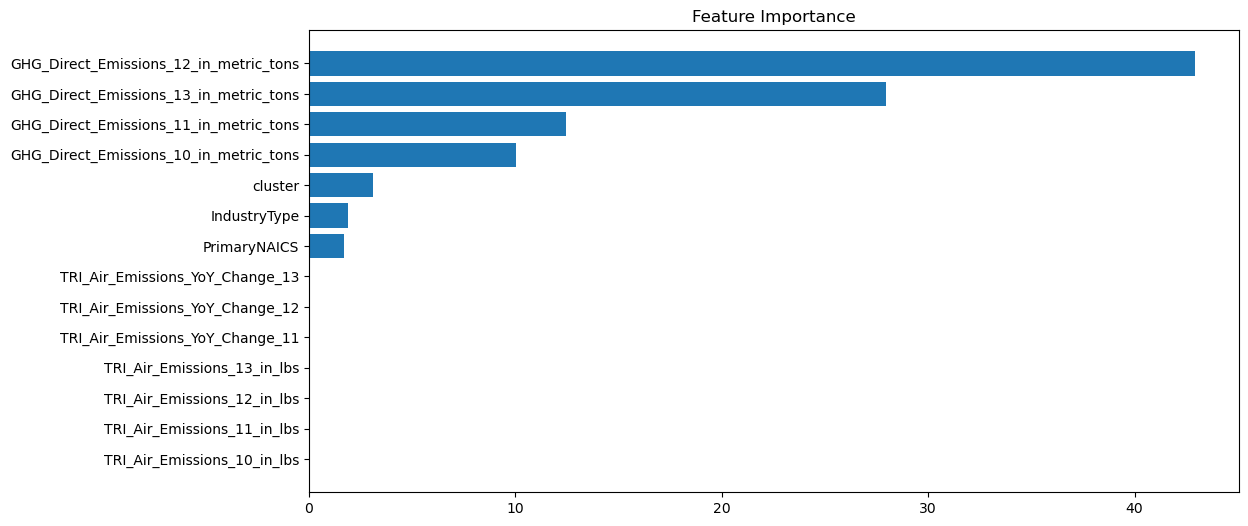

In [31]:

# show the feature importance
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, columns):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(model, train_df.columns)

In [32]:
submit  =  pd.read_csv ( 'sample_submission.csv' ,  header = None ) 
submit [ 1 ]  =  test_predictions 
submit.to_csv( 'submission_5.csv' ,  header = None ,  index = False )

In [33]:
# save train_df and test_df
train_df.to_csv('train_df_clustering.csv', index=False)
test_df.to_csv('test_df_clustering.csv', index=False)